<a href="https://colab.research.google.com/github/mrcruz117/Prophet-Parameter-Tuning-Dev/blob/main/Prophet_Parameter_Tuning_Dev.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prophet - Parameter Tuning
- dev env

In [2]:
#change directory
%cd /content/drive/MyDrive/Time Series Forecasting Product

/content/drive/MyDrive/Time Series Forecasting Product


In [3]:
#libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
#load the data
#YYYY-MM-DD
df = pd.read_csv('nyc_data.csv')
df.head()

,Date,Demand,Easter,Thanksgiving,Christmas,Temperature,Marketing
0,1/1/2015,720.000885,0,0,0,3.68,41.305
1,1/2/2015,581.276773,0,0,0,4.73,131.574
2,1/3/2015,754.117039,0,0,0,7.23,162.700
3,1/4/2015,622.252774,0,0,0,10.96,160.281
4,1/5/2015,785.373319,0,0,0,6.92,51.077


In [5]:
#Rename variable
df = df.rename(columns = {'Demand': 'y', 'Date' : 'ds'})
df.head(0)

,ds,y,Easter,Thanksgiving,Christmas,Temperature,Marketing


In [7]:
# Transforming Date: YYY-MM-DD
df.ds = pd.to_datetime(df.ds, format = '%m/%d/%Y')

In [8]:
df.head()

,ds,y,Easter,Thanksgiving,Christmas,Temperature,Marketing
0,2015-01-01,720.000885,0,0,0,3.68,41.305
1,2015-01-02,581.276773,0,0,0,4.73,131.574
2,2015-01-03,754.117039,0,0,0,7.23,162.700
3,2015-01-04,622.252774,0,0,0,10.96,160.281
4,2015-01-05,785.373319,0,0,0,6.92,51.077


## Holidays

In [10]:
# Easter
dates = df[df.Easter == 1].ds
easter = pd.DataFrame({
    'holiday': 'easter',
    'ds': dates,
    'lower_window': -5,
    'upper_window': 2,
})

,holiday,ds,lower_window,upper_window
94,easter,2015-04-05,-5,2
451,easter,2016-03-27,-5,2
836,easter,2017-04-16,-5,2
1186,easter,2018-04-01,-5,2
1571,easter,2019-04-21,-5,2
1928,easter,2020-04-12,-5,2


In [14]:
# Thanksgiving
dates = df[df.Thanksgiving == 1].ds
thanksgiving = pd.DataFrame({
    'holiday': 'thanksgiving',
    'ds': dates,
    'lower_window': -3,
    'upper_window': 5,
})
# Christmas
dates = df[df.Christmas == 1].ds
christmas = pd.DataFrame({
    'holiday': 'christmas',
    'ds': dates,
    'lower_window': -7,
    'upper_window': 7,
})

In [16]:
# combine all events
holidays = pd.concat([easter, thanksgiving, christmas])

holidays.head(5)

,holiday,ds,lower_window,upper_window
94,easter,2015-04-05,-5,2
451,easter,2016-03-27,-5,2
836,easter,2017-04-16,-5,2
1186,easter,2018-04-01,-5,2
1571,easter,2019-04-21,-5,2


In [18]:
# drop old holidays cols
df_final = df.drop(columns = ['Easter', 'Thanksgiving', 'Christmas'])
df_final.head()

,ds,y,Temperature,Marketing
0,2015-01-01,720.000885,3.68,41.305
1,2015-01-02,581.276773,4.73,131.574
2,2015-01-03,754.117039,7.23,162.700
3,2015-01-04,622.252774,10.96,160.281
4,2015-01-05,785.373319,6.92,51.077


## Parameters
- key parameters
  - **seasonality**: yearly, weekly, daily, etc
  - **seasonality mode**: multiplicative or additive
  - **holidays**
  - **seasonality_prior_scale**: strength of seasonality
  - **holiday_prior_scale**: how much do holidays interfere with the normal seasonal fluxuations
  - **changepoint_prior_scale**: how sensitive is the trendline to changes


## Prophet Model

In [19]:
from prophet import Prophet

In [20]:
# building the model
m = Prophet(
    holidays=holidays,
    seasonality_mode='multiplicative',
    seasonality_prior_scale=10,
    holidays_prior_scale=10,
    changepoint_prior_scale=0.05
)
m.add_regressor("Temperature")
m.add_regressor("Marketing")
# fit model
m.fit(df_final)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt68t3stb/4pruoz4_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt68t3stb/ugiz_irw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29077', 'data', 'file=/tmp/tmpt68t3stb/4pruoz4_.json', 'init=/tmp/tmpt68t3stb/ugiz_irw.json', 'output', 'file=/tmp/tmpt68t3stb/prophet_model_97cmjxq/prophet_model-20250218160101.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:01:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:01:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


## Cross-Validation

In [21]:
from prophet.diagnostics import cross_validation

In [22]:
# how many days in dataset?
df.shape[0] - 180

2012

In [24]:
df_cv = cross_validation(
    model = m,
    horizon = '31 days',
    period = '16 days',
    initial = '2012 days',
    parallel = 'processes'
)

INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f47fe042790>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt68t3stb/d59efsds.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt68t3stb/3jd6kczd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt68t3stb/u0j4oscj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8719', 'data', 'file=/tmp/tmpt68t3stb/3jd6kczd.json', 'init=/tmp/tmpt68t3stb/u0j4oscj.json', 'output', 'file=/tmp/tmpt68t3stb/prophet_model1l7k18tv/prophet_model-20250218161253.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:12:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt68t3stb/uk6aqewx.json
DEB

In [25]:
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2020-07-10,607.600343,544.459413,671.078133,571.069531,2020-07-09
1,2020-07-11,722.756372,660.321752,787.473295,677.106981,2020-07-09
2,2020-07-12,637.709391,570.836068,703.685297,619.572774,2020-07-09
3,2020-07-13,769.901813,702.107724,834.060916,808.932621,2020-07-09
4,2020-07-14,637.317035,568.345514,702.603963,661.791644,2020-07-09


Prophet comes with helpful functions to test performance

In [37]:
# performance metrics
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric

In [29]:
metrics = performance_metrics(df_cv)
metrics.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,4 days,2816.526046,53.070953,43.585827,0.059121,0.060690,0.060220,0.800000
1,5 days,2798.611929,52.901909,44.378974,0.062103,0.062914,0.062893,0.767742
2,6 days,3493.372151,59.104756,50.206298,0.069428,0.062736,0.070839,0.703226
3,7 days,2784.063423,52.764225,42.607514,0.060086,0.059503,0.061128,0.703226
4,8 days,2718.948136,52.143534,40.120799,0.055470,0.058671,0.056952,0.732258


In [36]:
rmse = round(performance_metrics(df_cv)['rmse'].mean(), 1)
mape = round(performance_metrics(df_cv)['mape'].mean() * 100, 3)

print(f"RMSE: {rmse}")
print(f"Mape: {mape}")

RMSE: 54.1
Mape: 5.864


/usr/local/lib/python3.11/dist-packages/prophet/plot.py:546: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])
/usr/local/lib/python3.11/dist-packages/prophet/plot.py:547: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])


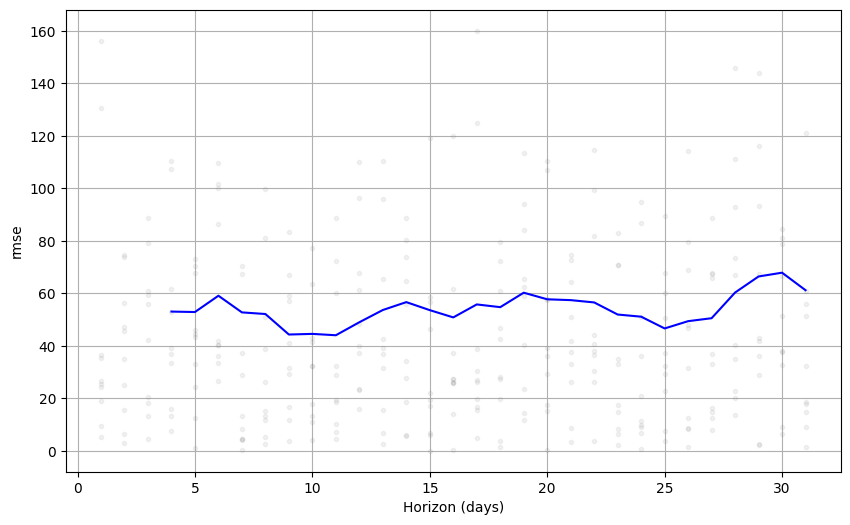

In [41]:
# plotting performance metrics overtime
plot_cross_validation_metric(
    df_cv,
    metric='rmse'
);
# error overtime

## Parameter Tuning

In [42]:
from sklearn.model_selection import ParameterGrid

In [43]:
param_grid = {
    'seasonality_mode': ['additive', 'multiplicative'],
    'seasonality_prior_scale': [5, 10, 20],
    'holidays_prior_scale': [5, 10, 20],
    'changepoint_prior_scale': [0.01, 0.05, 0.1],
    }
grid = ParameterGrid(param_grid)

In [44]:
# store
rmse = []
i = 0

# loop
for params in grid:
  print(f"PROGRESS: {i}/{len(list(grid))}")
# model
  m = Prophet(
      holidays=holidays,
      seasonality_mode=params['seasonality_mode'],
      seasonality_prior_scale=params['seasonality_prior_scale'],
      holidays_prior_scale=params['holidays_prior_scale'],
      changepoint_prior_scale=params['changepoint_prior_scale']
  )
  m.add_regressor("Temperature")
  m.add_regressor("Marketing")
  # fit model
  m.fit(df_final)

# cross-validation
  df_cv = cross_validation(
      model = m,
      horizon = '31 days',
      period = '16 days',
      initial = '2012 days',
      parallel = 'processes'
  )
# measure and store error
  err = round(performance_metrics(df_cv)['rmse'].mean(), 1)
  rmse.append(err)
  i += 1

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt68t3stb/1icnpj57.json


0/54


DEBUG:cmdstanpy:input tempfile: /tmp/tmpt68t3stb/psrjc6t0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58836', 'data', 'file=/tmp/tmpt68t3stb/1icnpj57.json', 'init=/tmp/tmpt68t3stb/psrjc6t0.json', 'output', 'file=/tmp/tmpt68t3stb/prophet_model8ger1fw9/prophet_model-20250218185804.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:58:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:58:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f47fd9fd690>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt68t3stb/xvlres5w.json
DEBUG:cmdstanpy:input tempfile:

1/54


DEBUG:cmdstanpy:input tempfile: /tmp/tmpt68t3stb/4wajty8n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57742', 'data', 'file=/tmp/tmpt68t3stb/ob6_h3jv.json', 'init=/tmp/tmpt68t3stb/4wajty8n.json', 'output', 'file=/tmp/tmpt68t3stb/prophet_modeliiwpabjz/prophet_model-20250218185812.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:58:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:58:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f47fe580d10>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt68t3stb/5bq7_7lm.json
DEBUG:cmdstanpy:input tempfile:

2/54


DEBUG:cmdstanpy:input tempfile: /tmp/tmpt68t3stb/d9wc51tt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42229', 'data', 'file=/tmp/tmpt68t3stb/48lc8qrv.json', 'init=/tmp/tmpt68t3stb/d9wc51tt.json', 'output', 'file=/tmp/tmpt68t3stb/prophet_model214996b6/prophet_model-20250218185821.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:58:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:58:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f47fd988610>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt68t3stb/t221m0lf.json
DEBUG:cmdstanpy:input tempfile:

3/54


DEBUG:cmdstanpy:input tempfile: /tmp/tmpt68t3stb/76evz3js.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79394', 'data', 'file=/tmp/tmpt68t3stb/tv0d8ial.json', 'init=/tmp/tmpt68t3stb/76evz3js.json', 'output', 'file=/tmp/tmpt68t3stb/prophet_model4z799t1l/prophet_model-20250218185830.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:58:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:58:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f47ed08a550>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt68t3stb/h6tj_417.json
DEBUG:cmdstanpy:input tempfile:

4/54


DEBUG:cmdstanpy:input tempfile: /tmp/tmpt68t3stb/6yha2dgt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99594', 'data', 'file=/tmp/tmpt68t3stb/5w3u8oby.json', 'init=/tmp/tmpt68t3stb/6yha2dgt.json', 'output', 'file=/tmp/tmpt68t3stb/prophet_modelxjbn27_p/prophet_model-20250218185838.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:58:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:58:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f47eb80f5d0>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt68t3stb/dwyi5ly3.json
DEBUG:cmdstanpy:input tempfile:

5/54


DEBUG:cmdstanpy:input tempfile: /tmp/tmpt68t3stb/0kcgz1l1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8889', 'data', 'file=/tmp/tmpt68t3stb/jogqtuo4.json', 'init=/tmp/tmpt68t3stb/0kcgz1l1.json', 'output', 'file=/tmp/tmpt68t3stb/prophet_modelbp0qp9k8/prophet_model-20250218185848.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:58:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:58:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f4805581b50>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt68t3stb/a65fm8g2.json
DEBUG:cmdstanpy:input tempfile: 

6/54


DEBUG:cmdstanpy:input tempfile: /tmp/tmpt68t3stb/cgpn62vz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15499', 'data', 'file=/tmp/tmpt68t3stb/4xvib_5b.json', 'init=/tmp/tmpt68t3stb/cgpn62vz.json', 'output', 'file=/tmp/tmpt68t3stb/prophet_modelryeclqy_/prophet_model-20250218185857.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:58:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:58:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f47eb62b310>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt68t3stb/9j4n2qoe.json
DEBUG:cmdstanpy:input tempfile:

7/54


DEBUG:cmdstanpy:input tempfile: /tmp/tmpt68t3stb/gzetftft.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21917', 'data', 'file=/tmp/tmpt68t3stb/y7euypgz.json', 'init=/tmp/tmpt68t3stb/gzetftft.json', 'output', 'file=/tmp/tmpt68t3stb/prophet_model6ziq0zk6/prophet_model-20250218185907.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:59:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:59:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f47ec670710>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt68t3stb/0u8rzkbw.json
DEBUG:cmdstanpy:input tempfile:

8/54


DEBUG:cmdstanpy:input tempfile: /tmp/tmpt68t3stb/tcwwzsz2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2108', 'data', 'file=/tmp/tmpt68t3stb/r67w7r84.json', 'init=/tmp/tmpt68t3stb/tcwwzsz2.json', 'output', 'file=/tmp/tmpt68t3stb/prophet_modelkto2a750/prophet_model-20250218185914.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:59:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:59:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f47eb9dc6d0>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt68t3stb/6hhqcwz4.json
DEBUG:cmdstanpy:input tempfile: 

9/54


DEBUG:cmdstanpy:input tempfile: /tmp/tmpt68t3stb/bzm06puc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15513', 'data', 'file=/tmp/tmpt68t3stb/tz_ywy9b.json', 'init=/tmp/tmpt68t3stb/bzm06puc.json', 'output', 'file=/tmp/tmpt68t3stb/prophet_model9j8q80vi/prophet_model-20250218185927.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:59:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:59:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f48015023d0>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt68t3stb/tneilxwv.json
DEBUG:cmdstanpy:input tempfile:

10/54


DEBUG:cmdstanpy:input tempfile: /tmp/tmpt68t3stb/iaiuo2i4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18198', 'data', 'file=/tmp/tmpt68t3stb/gvaywgy8.json', 'init=/tmp/tmpt68t3stb/iaiuo2i4.json', 'output', 'file=/tmp/tmpt68t3stb/prophet_modeltuihyv_r/prophet_model-20250218185935.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:59:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:59:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f47fda18c90>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt68t3stb/uzf3ttmz.json
DEBUG:cmdstanpy:input tempfile:

11/54


DEBUG:cmdstanpy:input tempfile: /tmp/tmpt68t3stb/iqtipbj6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75737', 'data', 'file=/tmp/tmpt68t3stb/g6ty20ka.json', 'init=/tmp/tmpt68t3stb/iqtipbj6.json', 'output', 'file=/tmp/tmpt68t3stb/prophet_modelj8mwkobn/prophet_model-20250218185947.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:59:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:59:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f47eb9af790>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt68t3stb/5wgr4gbw.json
DEBUG:cmdstanpy:input tempfile:

12/54


DEBUG:cmdstanpy:input tempfile: /tmp/tmpt68t3stb/1l637xo5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29881', 'data', 'file=/tmp/tmpt68t3stb/oeg37y38.json', 'init=/tmp/tmpt68t3stb/1l637xo5.json', 'output', 'file=/tmp/tmpt68t3stb/prophet_modelq03ui9wm/prophet_model-20250218185958.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:59:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:59:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f47fdee6790>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt68t3stb/u3zk9lio.json
DEBUG:cmdstanpy:input tempfile:

13/54


DEBUG:cmdstanpy:input tempfile: /tmp/tmpt68t3stb/8050lgz_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64434', 'data', 'file=/tmp/tmpt68t3stb/nyi3doma.json', 'init=/tmp/tmpt68t3stb/8050lgz_.json', 'output', 'file=/tmp/tmpt68t3stb/prophet_modelmq1v9x07/prophet_model-20250218190007.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:00:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:00:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f47eb5b9390>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt68t3stb/aacph24t.json
DEBUG:cmdstanpy:input tempfile:

14/54


DEBUG:cmdstanpy:input tempfile: /tmp/tmpt68t3stb/hovf6d3v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84004', 'data', 'file=/tmp/tmpt68t3stb/3pacois0.json', 'init=/tmp/tmpt68t3stb/hovf6d3v.json', 'output', 'file=/tmp/tmpt68t3stb/prophet_modeltg7e_rk0/prophet_model-20250218190017.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:00:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:00:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f47fd9fced0>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt68t3stb/au6vo8zm.json
DEBUG:cmdstanpy:input tempfile:

15/54


DEBUG:cmdstanpy:input tempfile: /tmp/tmpt68t3stb/i8es2gmm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69635', 'data', 'file=/tmp/tmpt68t3stb/8jxkzovt.json', 'init=/tmp/tmpt68t3stb/i8es2gmm.json', 'output', 'file=/tmp/tmpt68t3stb/prophet_model37gnkbfh/prophet_model-20250218190025.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:00:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:00:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f47ebcae190>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt68t3stb/zewksppy.json
DEBUG:cmdstanpy:input tempfile:

16/54


DEBUG:cmdstanpy:input tempfile: /tmp/tmpt68t3stb/td9wivcg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37175', 'data', 'file=/tmp/tmpt68t3stb/x6o3n8xn.json', 'init=/tmp/tmpt68t3stb/td9wivcg.json', 'output', 'file=/tmp/tmpt68t3stb/prophet_modelt7f99dmu/prophet_model-20250218190035.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:00:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:00:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f47ec0fb8d0>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt68t3stb/wto79qwh.json
DEBUG:cmdstanpy:input tempfile:

17/54


DEBUG:cmdstanpy:input tempfile: /tmp/tmpt68t3stb/jzaupk04.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10071', 'data', 'file=/tmp/tmpt68t3stb/bnn2s5nw.json', 'init=/tmp/tmpt68t3stb/jzaupk04.json', 'output', 'file=/tmp/tmpt68t3stb/prophet_modelvccpzvsb/prophet_model-20250218190045.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:00:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:00:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f47ed0b79d0>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt68t3stb/y56uiwla.json
DEBUG:cmdstanpy:input tempfile:

18/54


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt68t3stb/r6z8z0rn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt68t3stb/0rdwgdro.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73413', 'data', 'file=/tmp/tmpt68t3stb/r6z8z0rn.json', 'init=/tmp/tmpt68t3stb/0rdwgdro.json', 'output', 'file=/tmp/tmpt68t3stb/prophet_modelshve80o0/prophet_model-20250218190055.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:00:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:00:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <conc

19/54


DEBUG:cmdstanpy:input tempfile: /tmp/tmpt68t3stb/kne3k3ds.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45114', 'data', 'file=/tmp/tmpt68t3stb/bb5alhev.json', 'init=/tmp/tmpt68t3stb/kne3k3ds.json', 'output', 'file=/tmp/tmpt68t3stb/prophet_modelx99dy9l4/prophet_model-20250218190107.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:01:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:01:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f47ebae1910>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt68t3stb/tu4z2dii.json
DEBUG:cmdstanpy:input tempfile:

20/54


DEBUG:cmdstanpy:input tempfile: /tmp/tmpt68t3stb/4lcxwiif.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48316', 'data', 'file=/tmp/tmpt68t3stb/16jcqt46.json', 'init=/tmp/tmpt68t3stb/4lcxwiif.json', 'output', 'file=/tmp/tmpt68t3stb/prophet_model46zrr4xh/prophet_model-20250218190120.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:01:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:01:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f47ebbdd590>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt68t3stb/m3w6ifv9.json
DEBUG:cmdstanpy:input tempfile:

21/54


DEBUG:cmdstanpy:input tempfile: /tmp/tmpt68t3stb/ihmgfa7h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71046', 'data', 'file=/tmp/tmpt68t3stb/k1lcmcjj.json', 'init=/tmp/tmpt68t3stb/ihmgfa7h.json', 'output', 'file=/tmp/tmpt68t3stb/prophet_model9qvew562/prophet_model-20250218190133.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:01:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:01:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f47eb6c1c90>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt68t3stb/j_ho02ec.json
DEBUG:cmdstanpy:input tempfile:

22/54


DEBUG:cmdstanpy:input tempfile: /tmp/tmpt68t3stb/v_a_5ga1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45211', 'data', 'file=/tmp/tmpt68t3stb/kii8ha5_.json', 'init=/tmp/tmpt68t3stb/v_a_5ga1.json', 'output', 'file=/tmp/tmpt68t3stb/prophet_modelu_lmn9xa/prophet_model-20250218190143.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:01:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:01:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f47eb9d5050>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt68t3stb/7utz62zg.json
DEBUG:cmdstanpy:input tempfile:

23/54


DEBUG:cmdstanpy:input tempfile: /tmp/tmpt68t3stb/yzcn3dje.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88998', 'data', 'file=/tmp/tmpt68t3stb/jggn5z6_.json', 'init=/tmp/tmpt68t3stb/yzcn3dje.json', 'output', 'file=/tmp/tmpt68t3stb/prophet_model35tt6hzf/prophet_model-20250218190157.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:01:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:01:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f4800e20610>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt68t3stb/de8unm_f.json
DEBUG:cmdstanpy:input tempfile:

24/54


DEBUG:cmdstanpy:input tempfile: /tmp/tmpt68t3stb/nlk8yy5d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56755', 'data', 'file=/tmp/tmpt68t3stb/rx08y86s.json', 'init=/tmp/tmpt68t3stb/nlk8yy5d.json', 'output', 'file=/tmp/tmpt68t3stb/prophet_model_2lefz3x/prophet_model-20250218190210.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:02:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:02:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f47eb7dd010>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt68t3stb/keslice0.json
DEBUG:cmdstanpy:input tempfile:

25/54


DEBUG:cmdstanpy:input tempfile: /tmp/tmpt68t3stb/khflhouj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36829', 'data', 'file=/tmp/tmpt68t3stb/fkloj0du.json', 'init=/tmp/tmpt68t3stb/khflhouj.json', 'output', 'file=/tmp/tmpt68t3stb/prophet_modelvubxgbg5/prophet_model-20250218190222.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:02:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:02:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f47ed24a850>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt68t3stb/eno_rpr_.json
DEBUG:cmdstanpy:input tempfile:

26/54


DEBUG:cmdstanpy:input tempfile: /tmp/tmpt68t3stb/pki7r_yg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17173', 'data', 'file=/tmp/tmpt68t3stb/tp2s0yn8.json', 'init=/tmp/tmpt68t3stb/pki7r_yg.json', 'output', 'file=/tmp/tmpt68t3stb/prophet_model6pthrh0v/prophet_model-20250218190234.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:02:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:02:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f47fda3d690>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt68t3stb/yder7pk4.json
DEBUG:cmdstanpy:input tempfile:

27/54


DEBUG:cmdstanpy:input tempfile: /tmp/tmpt68t3stb/jnsb8yz1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62760', 'data', 'file=/tmp/tmpt68t3stb/3v98w8e6.json', 'init=/tmp/tmpt68t3stb/jnsb8yz1.json', 'output', 'file=/tmp/tmpt68t3stb/prophet_modelfilzmn6e/prophet_model-20250218190248.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:02:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:02:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f47ebe553d0>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt68t3stb/y9ul3_je.json
DEBUG:cmdstanpy:input tempfile:

28/54


DEBUG:cmdstanpy:input tempfile: /tmp/tmpt68t3stb/zgpj7n6u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53146', 'data', 'file=/tmp/tmpt68t3stb/_o2cams0.json', 'init=/tmp/tmpt68t3stb/zgpj7n6u.json', 'output', 'file=/tmp/tmpt68t3stb/prophet_modelc7vhfkg6/prophet_model-20250218190300.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:03:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:03:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f47ebadeed0>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt68t3stb/vq2dsupw.json
DEBUG:cmdstanpy:input tempfile:

29/54


DEBUG:cmdstanpy:input tempfile: /tmp/tmpt68t3stb/y9p7qtqo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54221', 'data', 'file=/tmp/tmpt68t3stb/l7mgonf2.json', 'init=/tmp/tmpt68t3stb/y9p7qtqo.json', 'output', 'file=/tmp/tmpt68t3stb/prophet_modelj3zuobi5/prophet_model-20250218190311.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:03:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:03:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f47f4397610>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt68t3stb/_ajs5cee.json
DEBUG:cmdstanpy:input tempfile:

30/54


DEBUG:cmdstanpy:input tempfile: /tmp/tmpt68t3stb/926q5425.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt68t3stb/bq_acxv0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30611', 'data', 'file=/tmp/tmpt68t3stb/926q5425.json', 'init=/tmp/tmpt68t3stb/bq_acxv0.json', 'output', 'file=/tmp/tmpt68t3stb/prophet_modelcfw6jl30/prophet_model-20250218190324.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:03:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:03:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f47f43949d0>
DEBUG:cmdstanpy:input tempfile:

31/54


DEBUG:cmdstanpy:input tempfile: /tmp/tmpt68t3stb/95w74jg7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63482', 'data', 'file=/tmp/tmpt68t3stb/m49tkt86.json', 'init=/tmp/tmpt68t3stb/95w74jg7.json', 'output', 'file=/tmp/tmpt68t3stb/prophet_modelhugoqx1d/prophet_model-20250218190338.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:03:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:03:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f47ebe40e50>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt68t3stb/nouu0kxn.json
DEBUG:cmdstanpy:input tempfile:

32/54


DEBUG:cmdstanpy:input tempfile: /tmp/tmpt68t3stb/m7sbzzje.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98107', 'data', 'file=/tmp/tmpt68t3stb/3u283rmm.json', 'init=/tmp/tmpt68t3stb/m7sbzzje.json', 'output', 'file=/tmp/tmpt68t3stb/prophet_model2ckeqox0/prophet_model-20250218190348.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:03:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:03:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f47ebbb1550>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt68t3stb/phocpcyw.json
DEBUG:cmdstanpy:input tempfile:

33/54


DEBUG:cmdstanpy:input tempfile: /tmp/tmpt68t3stb/rbqdtm1v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80066', 'data', 'file=/tmp/tmpt68t3stb/2u3s3jpp.json', 'init=/tmp/tmpt68t3stb/rbqdtm1v.json', 'output', 'file=/tmp/tmpt68t3stb/prophet_model_zcsl9pk/prophet_model-20250218190401.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:04:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:04:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f47eb80f190>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt68t3stb/mwv20fo_.json
DEBUG:cmdstanpy:input tempfile:

34/54


DEBUG:cmdstanpy:input tempfile: /tmp/tmpt68t3stb/_91lmhff.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20245', 'data', 'file=/tmp/tmpt68t3stb/qewq0vrw.json', 'init=/tmp/tmpt68t3stb/_91lmhff.json', 'output', 'file=/tmp/tmpt68t3stb/prophet_modellx3yjju0/prophet_model-20250218190414.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:04:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:04:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f47ebb78290>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt68t3stb/okl0no62.json
DEBUG:cmdstanpy:input tempfile:

35/54


DEBUG:cmdstanpy:input tempfile: /tmp/tmpt68t3stb/sglymp2d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55137', 'data', 'file=/tmp/tmpt68t3stb/9ipng5se.json', 'init=/tmp/tmpt68t3stb/sglymp2d.json', 'output', 'file=/tmp/tmpt68t3stb/prophet_modelkpqbx4u5/prophet_model-20250218190426.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:04:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:04:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f47fda1a250>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt68t3stb/w9wq7xq0.json
DEBUG:cmdstanpy:input tempfile:

36/54


DEBUG:cmdstanpy:input tempfile: /tmp/tmpt68t3stb/d0to59lm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31807', 'data', 'file=/tmp/tmpt68t3stb/9fx81qd2.json', 'init=/tmp/tmpt68t3stb/d0to59lm.json', 'output', 'file=/tmp/tmpt68t3stb/prophet_model3u_sj7hd/prophet_model-20250218190437.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:04:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:04:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f47eb7de150>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt68t3stb/4edjwms4.json
DEBUG:cmdstanpy:input tempfile:

37/54


DEBUG:cmdstanpy:input tempfile: /tmp/tmpt68t3stb/13iscv6d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82140', 'data', 'file=/tmp/tmpt68t3stb/f2o7ujl6.json', 'init=/tmp/tmpt68t3stb/13iscv6d.json', 'output', 'file=/tmp/tmpt68t3stb/prophet_modelh1bo05vs/prophet_model-20250218190454.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:04:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:04:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f47ec61fe90>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt68t3stb/orb_s678.json
DEBUG:cmdstanpy:input tempfile:

38/54


DEBUG:cmdstanpy:input tempfile: /tmp/tmpt68t3stb/_y3cmysf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42685', 'data', 'file=/tmp/tmpt68t3stb/ym0fe1rl.json', 'init=/tmp/tmpt68t3stb/_y3cmysf.json', 'output', 'file=/tmp/tmpt68t3stb/prophet_modelvg0uc3io/prophet_model-20250218190511.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:05:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:05:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f47ebadeb90>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt68t3stb/375e9kg1.json
DEBUG:cmdstanpy:input tempfile:

39/54


DEBUG:cmdstanpy:input tempfile: /tmp/tmpt68t3stb/jxlcmmtk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69367', 'data', 'file=/tmp/tmpt68t3stb/2etji464.json', 'init=/tmp/tmpt68t3stb/jxlcmmtk.json', 'output', 'file=/tmp/tmpt68t3stb/prophet_model6vi7disr/prophet_model-20250218190528.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:05:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:05:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f47eb9dc890>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt68t3stb/p_yy01vk.json
DEBUG:cmdstanpy:input tempfile:

40/54


DEBUG:cmdstanpy:input tempfile: /tmp/tmpt68t3stb/b92yqy45.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97517', 'data', 'file=/tmp/tmpt68t3stb/tsnrtuyx.json', 'init=/tmp/tmpt68t3stb/b92yqy45.json', 'output', 'file=/tmp/tmpt68t3stb/prophet_modelq40ecp1p/prophet_model-20250218190543.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:05:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:05:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f47ed051690>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt68t3stb/hdbs885z.json
DEBUG:cmdstanpy:input tempfile:

41/54


DEBUG:cmdstanpy:input tempfile: /tmp/tmpt68t3stb/j186zpan.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56028', 'data', 'file=/tmp/tmpt68t3stb/zmlmz4yp.json', 'init=/tmp/tmpt68t3stb/j186zpan.json', 'output', 'file=/tmp/tmpt68t3stb/prophet_modelvn7d731r/prophet_model-20250218190558.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:05:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:05:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f47ebd5e150>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt68t3stb/2xhns_dm.json
DEBUG:cmdstanpy:input tempfile:

42/54


DEBUG:cmdstanpy:input tempfile: /tmp/tmpt68t3stb/c7gakqw2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98290', 'data', 'file=/tmp/tmpt68t3stb/5dcm0qpb.json', 'init=/tmp/tmpt68t3stb/c7gakqw2.json', 'output', 'file=/tmp/tmpt68t3stb/prophet_modelz3luqvjj/prophet_model-20250218190614.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:06:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:06:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f47fd8f20d0>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt68t3stb/p4fg06rk.json
DEBUG:cmdstanpy:input tempfile:

43/54


DEBUG:cmdstanpy:input tempfile: /tmp/tmpt68t3stb/eux_g0sa.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91136', 'data', 'file=/tmp/tmpt68t3stb/frcs1svg.json', 'init=/tmp/tmpt68t3stb/eux_g0sa.json', 'output', 'file=/tmp/tmpt68t3stb/prophet_modellwte6328/prophet_model-20250218190631.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:06:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:06:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f47ebe2da90>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt68t3stb/bz2za25n.json
DEBUG:cmdstanpy:input tempfile:

44/54


DEBUG:cmdstanpy:input tempfile: /tmp/tmpt68t3stb/hjks_i77.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2168', 'data', 'file=/tmp/tmpt68t3stb/jq0w9h8c.json', 'init=/tmp/tmpt68t3stb/hjks_i77.json', 'output', 'file=/tmp/tmpt68t3stb/prophet_modelhxk4v7lp/prophet_model-20250218190647.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:06:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:06:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f47eb5b8f90>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt68t3stb/1q8yz0s7.json
DEBUG:cmdstanpy:input tempfile: 

45/54


DEBUG:cmdstanpy:input tempfile: /tmp/tmpt68t3stb/kih1vmev.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62221', 'data', 'file=/tmp/tmpt68t3stb/x2wcp_vi.json', 'init=/tmp/tmpt68t3stb/kih1vmev.json', 'output', 'file=/tmp/tmpt68t3stb/prophet_modelrq2dhanf/prophet_model-20250218190702.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:07:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:07:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f47ebb7a750>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt68t3stb/675g0wnd.json
DEBUG:cmdstanpy:input tempfile:

46/54


DEBUG:cmdstanpy:input tempfile: /tmp/tmpt68t3stb/qd5e6x8x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59389', 'data', 'file=/tmp/tmpt68t3stb/paxhfyhc.json', 'init=/tmp/tmpt68t3stb/qd5e6x8x.json', 'output', 'file=/tmp/tmpt68t3stb/prophet_modeljrw_rb26/prophet_model-20250218190718.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:07:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:07:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f47eb9ad510>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt68t3stb/0iqokxjd.json
DEBUG:cmdstanpy:input tempfile:

47/54


DEBUG:cmdstanpy:input tempfile: /tmp/tmpt68t3stb/7hl3fzd6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31305', 'data', 'file=/tmp/tmpt68t3stb/su08dotc.json', 'init=/tmp/tmpt68t3stb/7hl3fzd6.json', 'output', 'file=/tmp/tmpt68t3stb/prophet_modelr_0brem_/prophet_model-20250218190734.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:07:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:07:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f47ecc84c10>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt68t3stb/3s61ef67.json
DEBUG:cmdstanpy:input tempfile:

48/54


DEBUG:cmdstanpy:input tempfile: /tmp/tmpt68t3stb/38ko618y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96149', 'data', 'file=/tmp/tmpt68t3stb/_z8d_mvu.json', 'init=/tmp/tmpt68t3stb/38ko618y.json', 'output', 'file=/tmp/tmpt68t3stb/prophet_modelji780h9r/prophet_model-20250218190748.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:07:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:07:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f47fdee50d0>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt68t3stb/ng6ksdya.json
DEBUG:cmdstanpy:input tempfile:

49/54


DEBUG:cmdstanpy:input tempfile: /tmp/tmpt68t3stb/e6ivruvv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59879', 'data', 'file=/tmp/tmpt68t3stb/740egriu.json', 'init=/tmp/tmpt68t3stb/e6ivruvv.json', 'output', 'file=/tmp/tmpt68t3stb/prophet_model4q6mea42/prophet_model-20250218190804.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:08:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:08:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f47eb60ca50>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt68t3stb/5b6kgabg.json
DEBUG:cmdstanpy:input tempfile:

50/54


DEBUG:cmdstanpy:input tempfile: /tmp/tmpt68t3stb/jlo9tdl6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62916', 'data', 'file=/tmp/tmpt68t3stb/pf6m7oit.json', 'init=/tmp/tmpt68t3stb/jlo9tdl6.json', 'output', 'file=/tmp/tmpt68t3stb/prophet_modelcj4ektqf/prophet_model-20250218190821.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:08:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:08:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f47eb9acd90>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt68t3stb/supzx0b4.json
DEBUG:cmdstanpy:input tempfile:

51/54


DEBUG:cmdstanpy:input tempfile: /tmp/tmpt68t3stb/lismmh9n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30735', 'data', 'file=/tmp/tmpt68t3stb/k2iwrkal.json', 'init=/tmp/tmpt68t3stb/lismmh9n.json', 'output', 'file=/tmp/tmpt68t3stb/prophet_modelfbxu_xmb/prophet_model-20250218190837.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:08:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:08:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f47eb701b50>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt68t3stb/8hk1n6gi.json
DEBUG:cmdstanpy:input tempfile:

52/54


DEBUG:cmdstanpy:input tempfile: /tmp/tmpt68t3stb/_0qh68sn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70742', 'data', 'file=/tmp/tmpt68t3stb/7ruf8eb9.json', 'init=/tmp/tmpt68t3stb/_0qh68sn.json', 'output', 'file=/tmp/tmpt68t3stb/prophet_modelu8ahrhtz/prophet_model-20250218190852.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:08:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:08:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f47ec62fe10>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt68t3stb/0qsx29gs.json
DEBUG:cmdstanpy:input tempfile:

53/54


DEBUG:cmdstanpy:input tempfile: /tmp/tmpt68t3stb/ocjbtnvt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74492', 'data', 'file=/tmp/tmpt68t3stb/g_grdzjz.json', 'init=/tmp/tmpt68t3stb/ocjbtnvt.json', 'output', 'file=/tmp/tmpt68t3stb/prophet_modelrktm1bg1/prophet_model-20250218190908.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:09:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:09:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f47ebb01550>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt68t3stb/6ek7onia.json
DEBUG:cmdstanpy:input tempfile:

In [48]:
# view tuning outcomes
tuning_results = pd.DataFrame(grid)
tuning_results['rmse'] = rmse
tuning_results

,changepoint_prior_scale,holidays_prior_scale,seasonality_mode,seasonality_prior_scale,rmse
0,0.01,5,additive,5,48.5
1,0.01,5,additive,10,48.6
2,0.01,5,additive,20,48.7
3,0.01,5,multiplicative,5,49.6
4,0.01,5,multiplicative,10,49.9
5,0.01,5,multiplicative,20,49.6
6,0.01,10,additive,5,49.4
7,0.01,10,additive,10,49.1
8,0.01,10,additive,20,48.6
9,0.01,10,multiplicative,5,49.6


In [54]:
# exporting tuned parameters
best_params = tuning_results[tuning_results.rmse == tuning_results.rmse.min()].transpose()
best_params.to_csv('Forecasting Product/best_params_prophet.csv')